# Evan, Icentia analysis

## importing necessary modules and initializing global variables

In [6]:
import numpy as np
from scipy.fft import rfft, rfftfreq
import matplotlib.pyplot as plt
import os
import scipy.signal as signal
from Tools.ReadPatientData import readSubject
from Tools.AnalysisTools import *
import neurokit2 as nk
import pandas as pd

dataFolder = "100data"      
fs = 250  

## Find missing files


In [7]:
import os

# Define the directory where the files are located
directory = "ecg_rate_11k"  # Replace with your directory path

# Generate the expected filenames
expected_files = {f"{i:05}_ecg_rate.pkl.gz" for i in range(11000)}  # 00000 to 11000

actual_files = {files for files in os.listdir(directory)}

# Find the missing files
missing_files = expected_files - actual_files

if missing_files:
    print("Missing files:")
    for missing_file in sorted(missing_files):
        print(missing_file)
else:
    print("No missing files.")

FileNotFoundError: [Errno 2] No such file or directory: 'ecg_rate_11k'

## test, reading ecg_rate and ecg_clean files


In [ ]:
rate=pd.read_pickle('Test/00000_ecg_rate.pkl.gz', compression='gzip')
clean=pd.read_pickle('ecg_clean_filtered/00000_ecg_clean.pkl.gz', compression='gzip')
rows = clean["00000_subject"]
number_of_removal = rows[-1]
removed_sessions = rows[-2]
session = rows[:-2]

print(number_of_removal)
print(removed_sessions)
len(rows[0])

21
[0, 1, 5, 8, 9, 10, 11, 17, 18, 19, 20, 23, 25, 26, 27, 28, 37, 38, 41, 43, 44]


/var/folders/xv/64m91p097z5bhlb_0myjf3580000gn/T/ipykernel_13119/2310196799.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  number_of_removal = rows[-1]
/var/folders/xv/64m91p097z5bhlb_0myjf3580000gn/T/ipykernel_13119/2310196799.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  removed_sessions = rows[-2]
/var/folders/xv/64m91p097z5bhlb_0myjf3580000gn/T/ipykernel_13119/2310196799.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

1048577

# Important functions for analysis

/var/folders/xv/64m91p097z5bhlb_0myjf3580000gn/T/ipykernel_13119/784471692.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ecg_rate_neurokit = rate_rows[index]


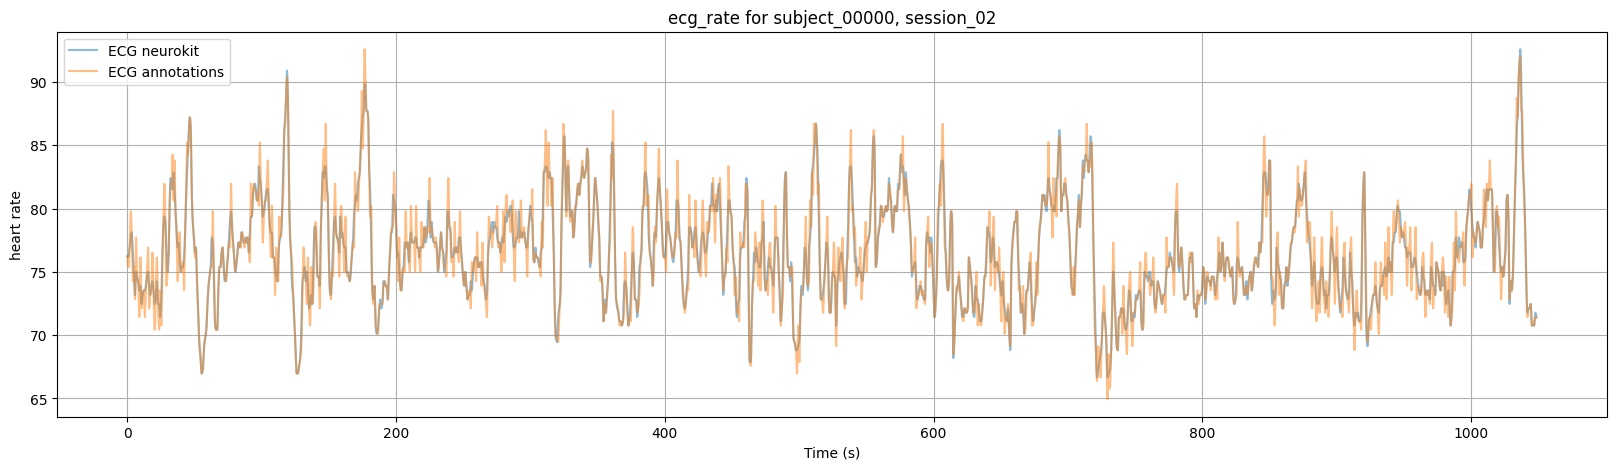

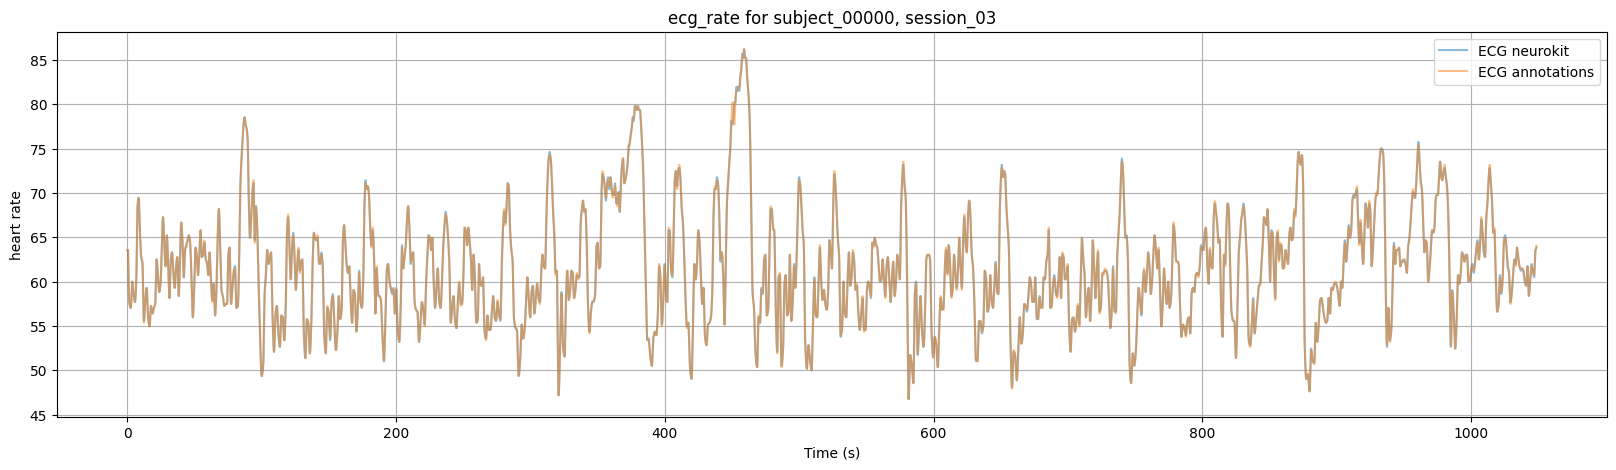

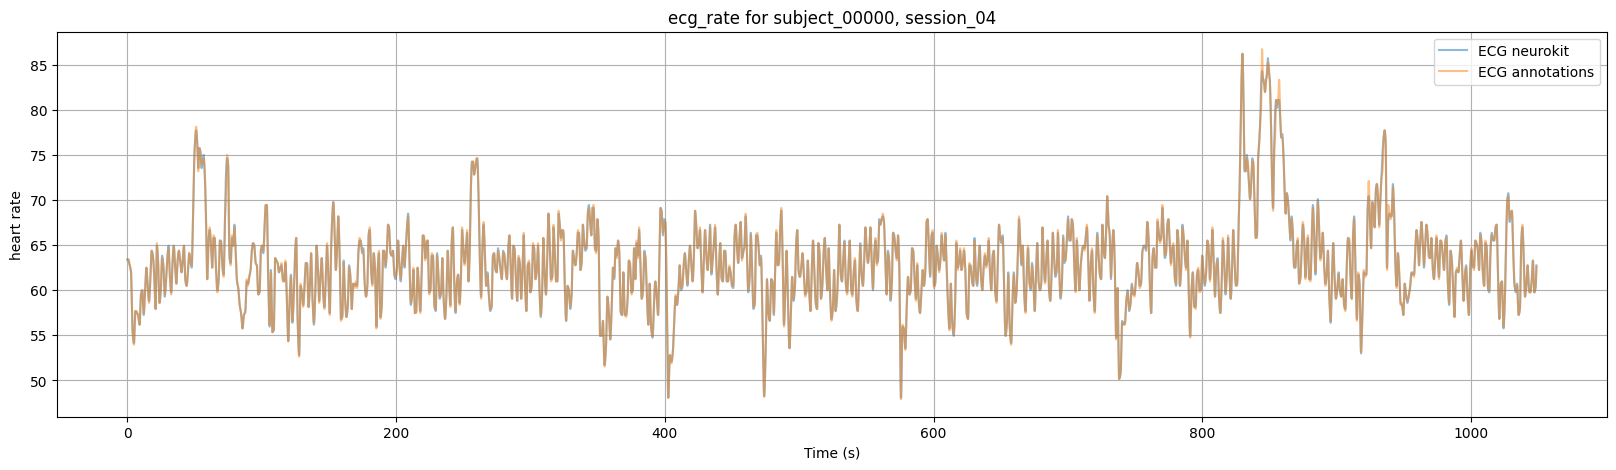

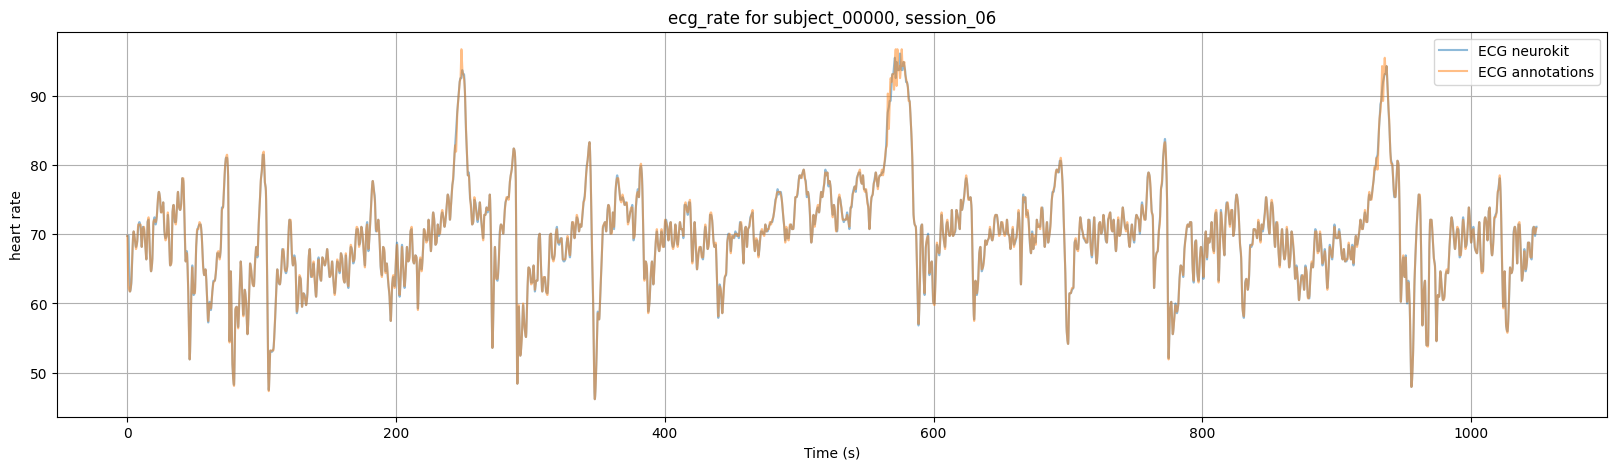

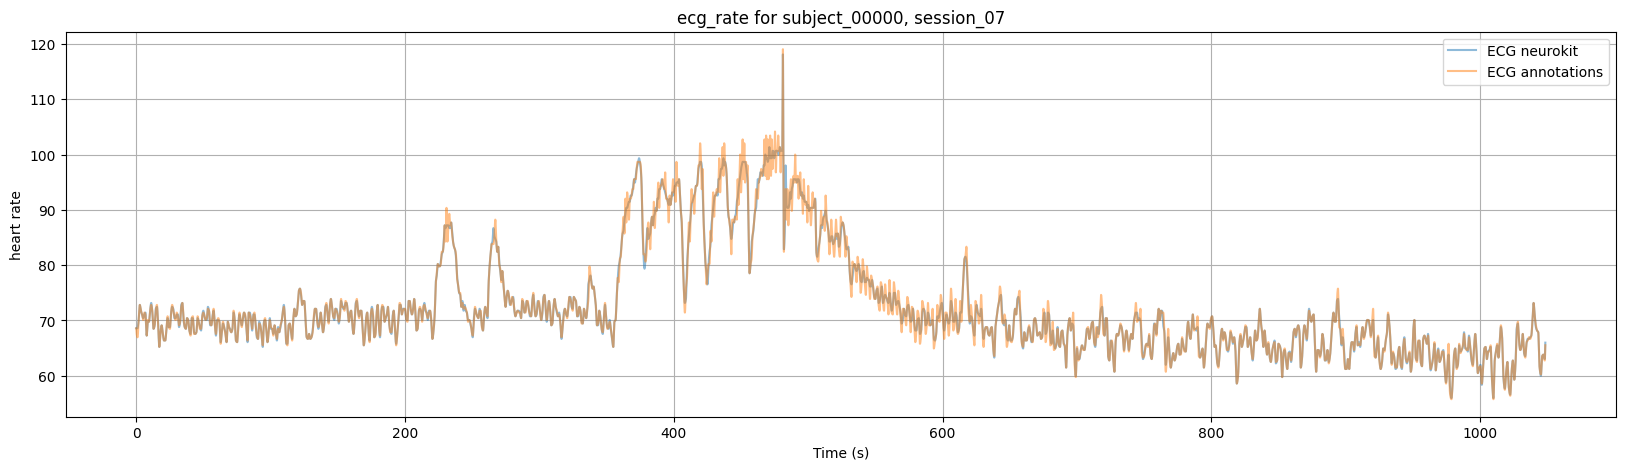

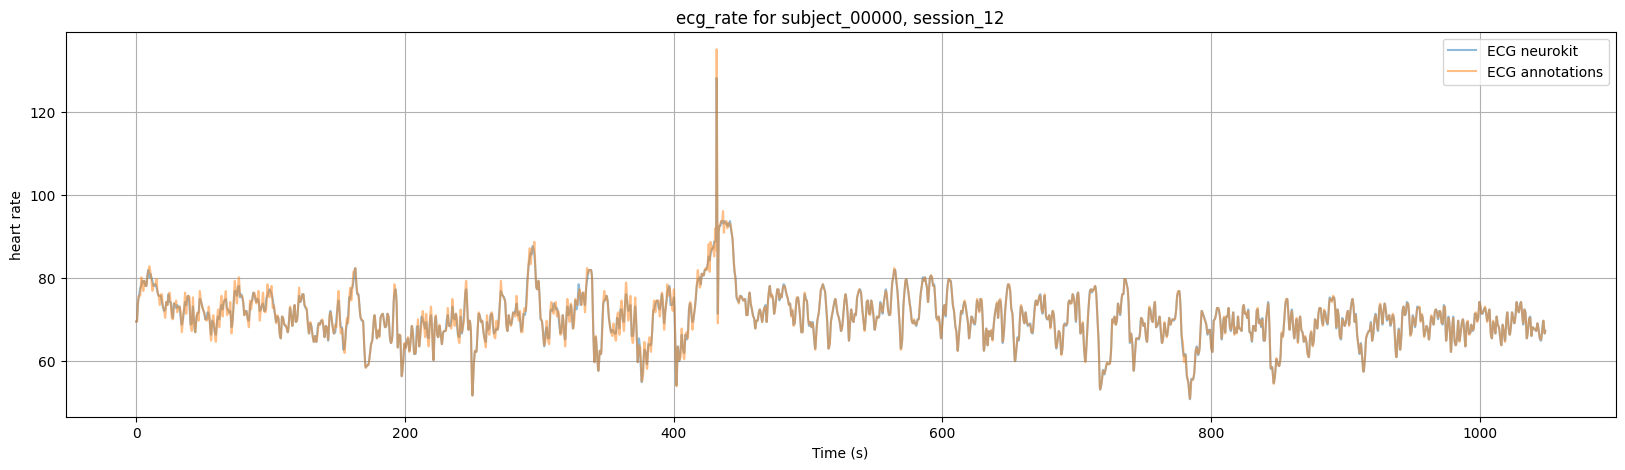

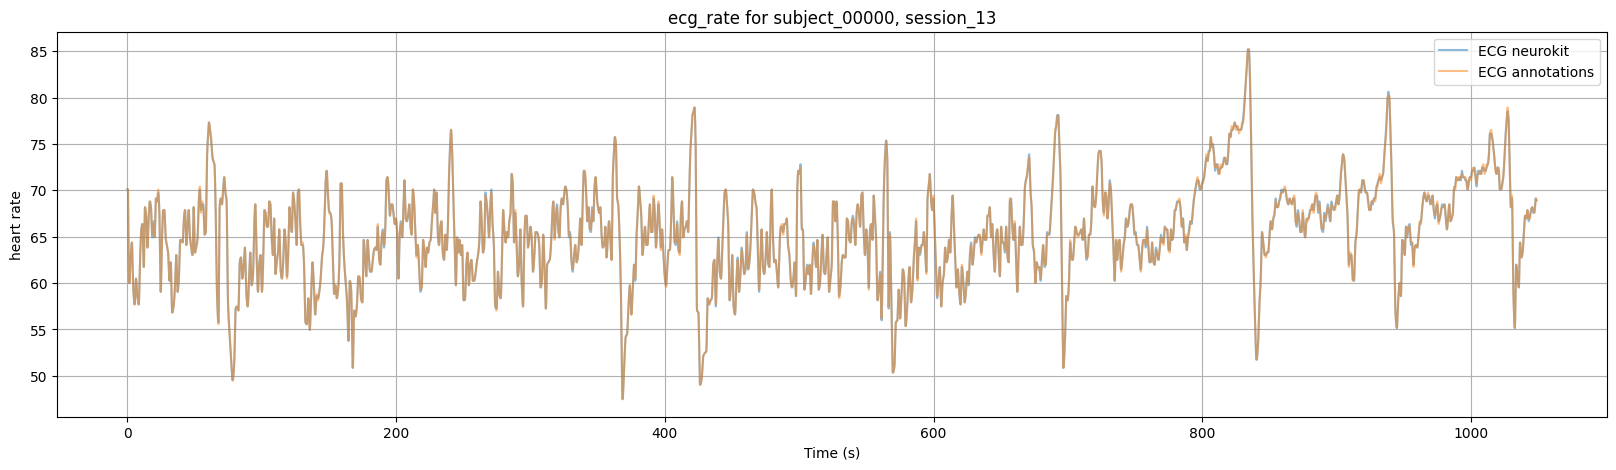

KeyboardInterrupt: 

In [ ]:
import re
import plotly.graph_objects as go

def plot_heart_rate(folder, subject):
    '''
    Plots all session heart rate (both neurokit and annotaions genearted on top of each other to compare differences)

    parameters:
    - folder:  folder where it contains the file "*****_ecg_rate.pkl.gz"
    - subject: subject id
    '''
    rate=pd.read_pickle(f'{folder}/{subject:05d}_ecg_rate.pkl.gz', compression='gzip')
    rate_rows = rate[f"{subject:05d}_subject"]
    sessions = rate_rows.keys()
    session_numbers = [int(re.search(r'\d+$', s).group()) for s in sessions if re.search(r'\d+$', s)]

    for index in range(len(sessions)-2):
        ECGTotal, annotationTotal = readSubject(subject, dataFolder)
        session_id = session_numbers[index]
        ecg = ECGTotal[session_id]
        annotation = annotationTotal[session_id]
        peaks = findPeaks(annotation, len(ecg))
        peak_positions = np.where(peaks == 1)[0]
        
        ecg_rate_neurokit = rate_rows[index]
        ecg_rate_annotations= nk.signal_rate(peak_positions, sampling_rate=fs, desired_length=len(ecg))

        time = (np.arange(len(ecg)) / fs)[:len(ecg)//4]


        y1 = ecg_rate_annotations[:len(ecg)//4]
        y2 = ecg_rate_neurokit[:len(ecg)//4]

        plt.figure(figsize=(20,5))
        plt.plot(time, y2, label='ECG neurokit', alpha=0.5, linestyle='-' )
        plt.plot(time, y1, label='ECG annotations', alpha=0.5, linestyle='-')
       

        plt.xlabel('Time (s)')
        plt.ylabel('heart rate')
        plt.title(f'ecg_rate for subject_{subject:05d}, session_{session_id:02d}')
        plt.legend()
        plt.grid(True)
        plt.show()

plot_heart_rate('Test',0)

In [ ]:
def ecg_rate_superimposed_plot(folder, subject, session_id):
    '''
    Plot heart rate (generated by annotations and neruokit) of a single session from a single subject on top of each other (intearctive)
    parameters:
    - folder: folder where it contains the file "*****_ecg_rate.pkl.gz"
    - subject: subject id
    - session_id: session that you want to plot
    '''
    rate=pd.read_pickle(f'{folder}/{subject:05d}_ecg_rate.pkl.gz', compression='gzip')
    rate_rows = rate[f"{subject:05d}_subject"]
    sessions = rate_rows.keys()
    session_numbers = [int(re.search(r'\d+$', s).group()) for s in sessions if re.search(r'\d+$', s)]

    ECGTotal, annotationTotal = readSubject(subject, dataFolder)
    ecg = ECGTotal[session_id]
    annotation = annotationTotal[session_id]
    peaks = findPeaks(annotation, len(ecg))
    peak_positions = np.where(peaks == 1)[0]


    ecg_rate_neurokit = rate_rows[session_numbers.index(session_id)]
    ecg_rate_annotations= nk.signal_rate(peak_positions, sampling_rate=fs, desired_length=len(ecg))

    time = (np.arange(len(ecg)) / fs)
    y = ecg_rate_neurokit
    y1 = ecg_rate_annotations

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=time, y=y, mode='lines', name='neurokit'))
    fig.add_trace(go.Scatter(x=time, y=y1, mode='lines', name='annotations'))
    # Add the R-peaks as red markers

    # Update layout for better visualization
    fig.update_layout(
        title=f"Interactive ecg_rate, subject: {subject:05d}, session: {session_id:02d}",
        xaxis_title="Time (s)",
        yaxis_title="Amplitude",
        showlegend=True
    )
    # Show the plot
    fig.show()


In [ ]:
import plotly.graph_objects as go

def compare_peaks_in_ecg_raw(folder, subject_id, session_id):
    '''
    Outputs two interactive plot: 
    - ecg_raw with rpeaks labeled using neurokit
    - ecg_raw with rpeaks and noise labeled using annotations

    parameters:
    - folder: folder that contains the annotations
    - subject_id: the subject you want to compare the two methods with
    - session_id: the session you want to compare the two methods with

    '''
    ecg_raw_total, annotation_total = readSubject(subject_id,f"{folder}")
    ecg_raw = ecg_raw_total[session_id]

    l = len(ecg_raw)/fs
    x = (np.arange(len(ecg_raw)) / fs)
    y = ecg_raw

    ecg_clean = nk.ecg_clean(ecg_raw, sampling_rate=250, method="neurokit")
    _, rpeaks = nk.ecg_peaks(ecg_clean, sampling_rate=fs)
    rpeaks = (rpeaks['ECG_R_Peaks'])

    
    annotation = annotation_total[session_id]
    peaks = findPeaks(annotation, len(ecg_raw))
    noises = find_noise(annotation, len(ecg_raw))

    noise_positions = np.where(noises == 1)[0]
    peak_positions = np.where(peaks == 1)[0]

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x, y=y, mode='lines', name='Raw ECG Signal'))
    # Add the R-peaks as red markers
    fig.add_trace(go.Scatter(x=x[rpeaks], y=y[rpeaks], mode='markers', name='R-peaks', marker=dict(color='red')))
    # Update layout for better visualization
    fig.update_layout(
        title=f"(Neurokit) Interactive Raw ECG Signal with R-peaks, subject: {subject_id:05d}, session: {session_id:02d}",
        xaxis_title="Time (s)",
        yaxis_title="Amplitude",
        showlegend=True
    )
    # Show the plot
    fig.show()

    fig1 = go.Figure()
    fig1.add_trace(go.Scatter(x=x, y=y, mode='lines', name='Raw ECG Signal'))
    # Add the R-peaks as red markers
    fig1.add_trace(go.Scatter(x=x[peak_positions], y=y[peak_positions], mode='markers', name='R-peaks', marker=dict(color='red')))
    fig1.add_trace(go.Scatter(x=x[noise_positions], y=y[noise_positions], mode='markers', name='noises', marker=dict(color='yellow')))
    # Update layout for better visualization
    fig1.update_layout(
        title=f"(Annotations) Interactive Raw ECG Signal with R-peaks, subject: {subject_id:05d}, session: {session_id:02d}",
        xaxis_title="Time (s)",
        yaxis_title="Amplitude",
        showlegend=True
    )
    # Show the plot
    fig1.show()

compare_peaks_in_ecg_raw("100data",1,2)


In [ ]:
def process_ecg_rate(ecg_rate, detrend, filter_enabled, highcut, fs):
    '''
    pre-processing ecg_rate, detrend, filter, highcut
    
    parameters:
    - ecg_rate: the ecg rate beings processed
    - detrend: boolean values, determines to detrend or not
    - filter_enabled: boolean values, determines to filter or not
    - highcut: filter highcut
    - fs: sampling frequency
    '''
    if detrend:
        ecg_rate = signal.detrend(ecg_rate)

    if filter_enabled:
        ecg_rate = nk.signal_filter(
            ecg_rate,
            highcut=highcut,
            sampling_rate=fs,
        )
    return ecg_rate

def compute_fft(ecg_rate, fs):
    '''
    computes the fft given ecg_rate and fs
    '''
    N = len(ecg_rate)
    fft_values = np.abs(rfft(ecg_rate))
    freqs = rfftfreq(N, 1 / fs)
    
   
    window_size = 8
    smooth_fft = np.convolve(fft_values, np.ones(window_size) / window_size, mode='same')
    return freqs, smooth_fft

In [ ]:
def sliding_window(data, window_time, overlap, noises, sampling_frequency=250):
    '''
    splits a session into segemnts given the desired time, overalp, and remove all the segments with noises

    parameters:
    - data: the session being segmented
    - window_time: time of the window in minutes
    - overlap: percent overlap you want (from 0 to 1)
    - noises: an array of 0 and 1 indicating the position of noise
    '''
    window_length = int(window_time * 60 * sampling_frequency)
    step_size = int(window_length * (1 - overlap))
    
    # Initialize dictionaries to hold windows with and without noise
    windows = {}
    removed_windows = {}
    segment = 0

    # Iterate over the data using the calculated step size and window length
    for start in range(0, len(data), step_size):
        window = data[start:start + window_length]
        noise_window = noises[start:start + window_length]
        
        if np.any(noise_window): 
            removed_windows[segment] = window
        else:
            windows[f'segment_{segment}'] = window
        
        segment += 1
    
    return windows, removed_windows

In [ ]:
import re
def save_psd(annotations_folder, neurokit_folder, subject, overlap,length, plot=True):
    annotation_rates=pd.read_pickle(f'{annotations_folder}/{subject:05d}_ecg_rate.pkl.gz', compression='gzip')
    neurokit_rates=pd.read_pickle(f'{neurokit_folder}/{subject:05d}_ecg_rate.pkl.gz', compression='gzip')

    neurokit_rows = neurokit_rates[f"{subject:05d}_subject"][:-2]
    annotation_rows = annotation_rates[f"{subject:05d}_subject"][:-2]

    a_session_names = (annotation_rows.keys())
    n_session_names = (neurokit_rows.keys())
    common_session_names = list(set(a_session_names) & set(n_session_names))

    neurokit_rows = {key: value for key, value in neurokit_rows.items() if key in common_session_names}
    annotation_rows = {key: value for key, value in annotation_rows.items() if key in common_session_names}
   
    session_numbers = sorted([int(re.search(r'\d+$', s).group()) for s in common_session_names if re.search(r'\d+$', s)])

    neurokit_rates = list(neurokit_rows.values())
    annotation_rates = list(annotation_rows.values())

    _, annotations = readSubject(subject,"100data")
    number_of_sessions = len(common_session_names)

    a_PSD = []
    n_PSD =[]

    for session in range(number_of_sessions):
        neurokit_rate = neurokit_rates[session]
        annotation_rate = annotation_rates[session]
        annotation = annotations[session_numbers[session]]

        noises = find_noise(annotation, len(neurokit_rate))
        a_windows, _ = sliding_window(annotation_rate,window_time=length, overlap=overlap, noises=noises)
        n_windows, n_removed_windows = sliding_window(neurokit_rate,window_time=length, overlap=overlap, noises=noises)

        a_segmented_rates = list(a_windows.values())
        segment_ids = list(a_windows.keys())

        n_segmented_rates = list(n_windows.values())
  
        
        for i in range(len(n_segmented_rates)):
            a_rate = a_segmented_rates[i]
            n_rate = n_segmented_rates[i]
            segment = segment_ids[i]
            try:
                a_rate_d = process_ecg_rate(a_rate, True, True, highcut = 0.35, fs=fs)
                n_rate_d = process_ecg_rate(n_rate, True, True, highcut = 0.35, fs=fs)

                a_freqs, a_fft = compute_fft(a_rate_d, fs)
                n_freqs, n_fft = compute_fft(n_rate_d, fs)

                a_PSD.append((a_freqs, a_fft))
                n_PSD.append((n_freqs, n_fft))
            


                if plot:
                    time = (np.arange(len(a_rate))/fs)/60

                    plt.figure(figsize=(20, 10))

                    # Plot ECG Rate segment on the left
                    plt.subplot(2, 2, 1)
                    plt.plot(time, a_rate, color='blue')
                    plt.xlabel('Time (minutes)')
                    plt.ylabel('ECG Rate')
                    plt.title(f'(annotations) ECG Rate(Subject_{subject:05d}_Session_{session_numbers[session]:02d}_Segment_{segment})')
                    plt.grid(True)

                    # Plot PSD on the right
                    plt.subplot(2, 2, 2)
                    plt.plot(a_freqs, a_fft, color='red')
                    plt.xlabel('Frequency (Hz)')
                    plt.ylabel('Magnitude')
                    plt.title(f'(annotations) Power Spectral Density (Subject_{subject:05d}_Session_{session_numbers[session]:02d}_Segment_{segment})')
                    plt.xlim(0, 0.35)
                    plt.grid(True)
                    plt.tight_layout()
                    plt.show()

                    plt.figure(figsize=(20, 10))

                    # Plot ECG Rate segment on the left
                    plt.subplot(2, 2, 3)
                    plt.plot(time, n_rate, color='blue')
                    plt.xlabel('Time (minutes)')
                    plt.ylabel('ECG Rate')
                    plt.title(f'(neurokit) ECG Rate(Subject_{subject:05d}_Session_{session_numbers[session]:02d}_Segment_{segment})')
                    plt.grid(True)

                    # Plot PSD on the right
                    plt.subplot(2, 2, 4)
                    plt.plot(n_freqs, n_fft, color='red')
                    plt.xlabel('Frequency (Hz)')
                    plt.ylabel('Magnitude')
                    plt.title(f'(neurokit) Power Spectral Density (Subject_{subject:05d}_Session_{session_numbers[session]:02d}_Segment_{segment})')
                    plt.xlim(0, 0.35)
                    plt.grid(True)
                    plt.tight_layout()
                    plt.show()
            except:
                print(f'error proceesing (Subject_{subject:05d}_Session_{session_numbers[session]:02d}_Segment_{segment})')
                
        if plot:
            plt.figure(figsize=(16, 5))
            whole_time = (np.arange(len(neurokit_rate)) /fs)/ 60
            plt.plot(whole_time, neurokit_rate, color='blue', label='ECG_rate Data')

            for removed in n_removed_windows.keys():
                start = removed * (length * (1 - overlap))
                end = start + length
                plt.axvspan(start, end, color='red', alpha=0.3)
            
            plt.xlabel('Time (minutes)')
            plt.ylabel('ECG rate Data')
            plt.title(f'Entire ECG Rate Data (Session {session_numbers[session]}) with Removed Segments Highlighted')
            plt.legend()
            plt.grid(True)
            plt.show()
    return (a_PSD, n_PSD)


a_PSD, n_PSD = save_psd(annotations_folder='ECG_rate_annotations', neurokit_folder="Test", subject=0,overlap=0, length=5, plot=False)

NameError: name 'pd' is not defined

In [5]:
def calculate_differences(a_PSD,n_PSD):
    
    abs_differences = []
    for i in range (len(n_PSD)):
         _, a_fft = a_PSD[i]
         _, n_fft = n_PSD[i]
         a_fft = np.array(a_fft)
         n_fft = np.array(n_fft)

         differences = a_fft - n_fft
    
         abs_difference = np.sum(np.abs(differences))
         abs_differences.append(abs_difference)

    return(abs_differences)
    


diff = calculate_differences(a_PSD, n_PSD)


NameError: name 'a_PSD' is not defined

In [ ]:
a_PSDs, n_PSDs = [],[]
for i in range(100):
    a_PSD, n_PSD = save_psd(annotations_folder='ECG_rate_annotations', neurokit_folder="Test", subject=i,overlap=0, length=5, plot=False)
    a_PSDs.append(a_PSD)
    n_PSDs.append(n_PSD)

    

error proceesing (Subject_00008_Session_49_Segment_segment_0)
error proceesing (Subject_00008_Session_49_Segment_segment_1)
error proceesing (Subject_00008_Session_49_Segment_segment_2)
error proceesing (Subject_00008_Session_49_Segment_segment_3)
error proceesing (Subject_00008_Session_49_Segment_segment_4)
error proceesing (Subject_00008_Session_49_Segment_segment_5)
error proceesing (Subject_00008_Session_49_Segment_segment_6)
error proceesing (Subject_00008_Session_49_Segment_segment_7)
error proceesing (Subject_00008_Session_49_Segment_segment_8)
error proceesing (Subject_00008_Session_49_Segment_segment_9)
error proceesing (Subject_00008_Session_49_Segment_segment_10)
error proceesing (Subject_00008_Session_49_Segment_segment_11)
error proceesing (Subject_00008_Session_49_Segment_segment_12)
error proceesing (Subject_00008_Session_49_Segment_segment_13)
error proceesing (Subject_00080_Session_45_Segment_segment_1)
error proceesing (Subject_00080_Session_45_Segment_segment_2)
erro

NameError: name 'a_PSDs' is not defined

<Figure size 1500x400 with 0 Axes>

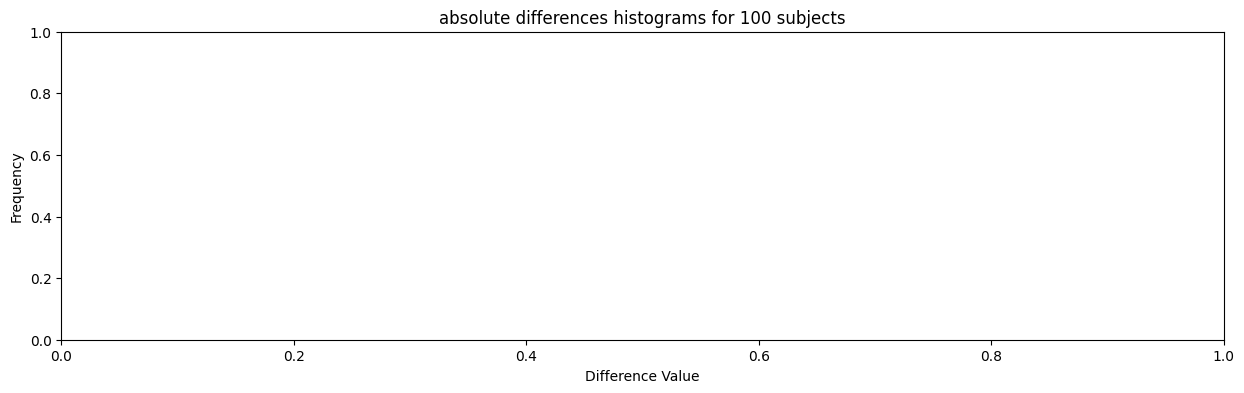

In [4]:
import matplotlib.pyplot as plt
all_diffs = []
fig = plt.figure(figsize=(15, 4))
fig, ax = plt.subplots(figsize=(15, 4))
plt.xlabel("Difference Value")
plt.ylabel("Frequency")

#ax.set_xlim(0,1e7)
ax.set_title("absolute differences histograms for 100 subjects")
for i in range(len(a_PSDs)):
    a_PSD = a_PSDs[i]
    n_PSD = n_PSDs[i]
    diff = calculate_differences(a_PSD,n_PSD)
    ax.hist(diff, alpha=0.5, edgecolor='black',bins=30)
    all_diffs.append(diff)




In [3]:
flattened_all_diff = [item for sublist in all_diffs for item in sublist]


counts, bins, _ = plt.hist(flattened_all_diff, bins = 100, alpha = 0.8, edgecolor = "black")
plt.title("Histogram_100_subjects")
plt.xlabel("Difference Value")
plt.ylabel("Frequency")

peak_bin_index = np.argmax(counts)  
peak_value = (bins[peak_bin_index]) 

# std deviation of the data and filter
std_dev = np.std(flattened_all_diff)
k = 1
upper_bound = peak_value + k * std_dev
filtered_diffs = [x for x in flattened_all_diff if x <= upper_bound]

NameError: name 'all_diffs' is not defined

In [ ]:
neurokit_rates=pd.read_pickle(f'Test/00080_ecg_rate.pkl.gz', compression='gzip')
annotation_rates=pd.read_pickle('ECG_rate_annotations/00080_ecg_rate.pkl.gz', compression='gzip')

neurokit_rates
annotation_rates

,00080_subject
session_04,"[62.0437816944134, 62.0437816944134, 62.043781..."
session_06,"[92.32789925056015, 92.32789925056015, 92.3278..."
session_08,"[109.05386495939932, 109.05386495939932, 109.0..."
session_09,"[83.00769607146502, 83.00769607146502, 83.0076..."
session_10,"[82.64383977168018, 82.64383977168018, 82.6438..."
session_11,"[84.27038632749942, 84.27038632749942, 84.2703..."
session_12,"[80.22101913744163, 80.22101913744163, 80.2210..."
session_13,"[77.56427196914983, 77.56427196914983, 77.5642..."
session_14,"[66.87715817387488, 66.87715817387488, 66.8771..."
session_17,"[74.11915536595976, 74.11915536595976, 74.1191..."


In [ ]:
def filter_PSD(a_PSDs,n_PSDs,threshold):
    filtered_a_PSDs = []
    filtered_n_PSDs = []

    for i in range(len(a_PSDs)):
        a_PSD = a_PSDs[i]
        n_PSD = n_PSDs[i]
        differences = calculate_differences(a_PSD,n_PSD)

        filtered_a_segments = []
        filtered_n_segments = []

        for j in range(len(differences)):
            if differences[j] <= threshold: 
                filtered_a_segments.append(a_PSD[j])  
                filtered_n_segments.append(n_PSD[j]) 

        if filtered_a_segments and filtered_n_segments:
            filtered_a_PSDs.append(filtered_a_segments)
            filtered_n_PSDs.append(filtered_n_segments)

    return filtered_a_PSDs, filtered_n_PSDs

a,b = filter_PSD(a_PSDs,n_PSDs, 1e6)


NameError: name 'a_PSDs' is not defined

In [ ]:
c = []
for i in range(len(a)):
    a1 = a[i]
    b1 = b[i]
    diff = calculate_differences(a1,b1)
    c.append(diff)




NameError: name 'a' is not defined

Text(0, 0.5, 'Frequency')

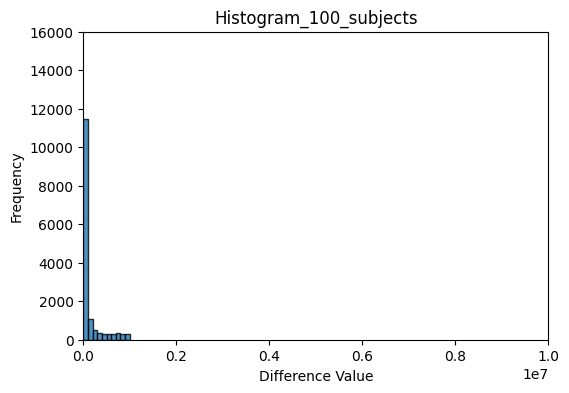

In [ ]:
d = [item for sublist in c for item in sublist]

fig = plt.figure(figsize=(6, 4))
plt.xlim(0,1e7)
plt.ylim(0,16000)
counts, bins, _ = plt.hist(d, bins = 10, alpha = 0.8, edgecolor = "black")
plt.title("Histogram_100_subjects")
plt.xlabel("Difference Value")
plt.ylabel("Frequency")

In [ ]:
len(d)/len(flattened_all_diff)

0.44143697919701647